# assignment_1_09_file_2

<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: 9 </center></h4>
<h4><center> Group Member 1: Lee Wei Qing, A0205666B </center></h4>
<h4><center> Group Member 2: Madeline Lim Chia Bing, A0205053W </center></h4>
<h4><center> Group Member 3: Mabel Lee Wei Ling, A0204397B </center></h4>
<h4><center> Group Member 4: Wu Wei Ye, A0200578H </center></h4>



## **Contents**
### 1. Isolation of Features and Ensemble of models
> #### 1.1 Feature Isolation with pre-trained Landmark Detection Model
> #### 1.2 Data Exploration
> #### 1.3 Training on Individual Isolated Features
> #### 1.4 Ensemble of models



In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [ ]:
# file paths
path = "./img_celeba_small/"
path_csv = "celeba.csv"

In [ ]:
attribute = pd.read_csv(path_csv)

In [ ]:
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f))
                 and f.endswith(".jpg")]
                 
# sort the images by alphabetical order 
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [ ]:
# reading in N_to_load numbers of images and converting to array
start_time = time.time()
df = []

N_to_load = 20000
start = time.time()
for k, file in enumerate(all_img[:N_to_load]):
    im = imageio.imread(os.path.join(path, file)).astype(float)
    im = resize(im, (100,100) )

    df.append(im)

    n_files_loaded_so_far = k+1
    if n_files_loaded_so_far % 1000 == 0:
      speed = n_files_loaded_so_far / (time.time() - start )
      print(f"Files loaded: {n_files_loaded_so_far} \t Loading Speed: {speed:2.1f} files loaded per second")
print("Took", time.time() - start_time, "to run")

Files loaded: 1000 	 Loading Speed: 164.7 files loaded per second
Files loaded: 2000 	 Loading Speed: 162.0 files loaded per second
Files loaded: 3000 	 Loading Speed: 164.4 files loaded per second
Files loaded: 4000 	 Loading Speed: 161.5 files loaded per second
Files loaded: 5000 	 Loading Speed: 163.4 files loaded per second
Files loaded: 6000 	 Loading Speed: 159.2 files loaded per second
Files loaded: 7000 	 Loading Speed: 160.8 files loaded per second
Files loaded: 8000 	 Loading Speed: 157.2 files loaded per second
Files loaded: 9000 	 Loading Speed: 154.2 files loaded per second
Files loaded: 10000 	 Loading Speed: 155.4 files loaded per second
Files loaded: 11000 	 Loading Speed: 158.1 files loaded per second
Files loaded: 12000 	 Loading Speed: 157.9 files loaded per second
Files loaded: 13000 	 Loading Speed: 159.4 files loaded per second
Files loaded: 14000 	 Loading Speed: 160.0 files loaded per second
Files loaded: 15000 	 Loading Speed: 158.1 files loaded per second
File

In [ ]:
# import the necessary packages
# pip install cmake
# pip install dlib
# pip install --upgrade imutils
from imutils import face_utils
import argparse
import imutils
import dlib
import cv2
import copy

# 1. Isolation of Features and Ensemble of models


## 1.1 Features isolation with pre-trained Landmark detection Model
Refer to the link below for more information https://pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/


The landmark detection which returns a tuple of 68 coordinates

We used a pretrained landmark detection model to isolate areas we want, export as new images/ store as list to be included as parameters when we rerun models on pictures. **Please download the pretrain model here:** https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

In [ ]:
# import the necessary packages
# pip install cmake
# pip install dlib
# pip install --upgrade imutils
from imutils import face_utils
import argparse
import imutils
import dlib
import cv2
import copy

In [ ]:
# Defining helper functions

# Converts output of Dlib from face detection to match OpenCV
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (a,b,c,d), the 4 bounding corners
    a = rect.bottom() #ymin
    b = rect.top()  #ymax
    c = rect.left()  #xmin
    d = rect.right() #max

    return np.array([b,a,c,d])
 
 # Converts output from dlib which gives us shape object to a numoy array that contains the 68 coordinates
 
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [ ]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor

# !wget -P /content/drive/MyDrive/DSA4212_Project/Assignment1 https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [ ]:
# Now, need to isolate coordinates of face parts
# https://s3.ap-south-1.amazonaws.com/s3.studytonight.com/curious/uploads/pictures/1592469192-74364.png
# eyes: 18 - 2 - 27 - 16
# mouth: 3 - 6 - 15 - 12
# ears 

def block(x):
    # let x be a tuple of 4 points - left up , left down, right up, right dow-> these points is plucked from diagram of 68 points
    # return array of 4 coordinates, which are the boundary of the box to be drawn

    # find the max x coordinates
    a = min(shape[x[0],0],shape[x[1],0])
    b = max(shape[x[2],0],shape[x[3],0])

    # find the max y coordinates
    c = min(shape[x[0],1],shape[x[1],1])
    d = max(shape[x[2],1],shape[x[3],1])

    return np.array([c,d,a,b])

eyes = np.array([18, 3, 27, 15])
mouth = np.array([2, 7, 16, 11])


ec_all = []
mc_all = []
face_all = []

for i in range(0,N_to_load):                      

    # load the input image, resize it, and convert it to grayscale
    image = df[i]
    gray = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        face = rect_to_bb(rect)

    #Returns array with [y[min],y[max],x[min],x[max]]
    ec = block(eyes) 
    mc = block(mouth)

    #append to respective lists
    ec_all.append(ec)
    mc_all.append(mc)
    face_all.append(face)

In [ ]:
def eyescropped(im, k):
    ec = ec_all[k]
    im = im[ec[0]:ec[1],ec[2]:ec[3]]
    im = resize(im, (30,90))
    return im


def mouthcropped(im, k):
    mc = mc_all[k]
    im = im[mc[0]:mc[1],mc[2]:mc[3]]
    im = resize(im, (30,90))
    return im


def earscropped(im, k):
    ec = ec_all[k]
    left = im[ec[0]:ec[1],0:ec[2]] #end of photo to left eye
    right = im[ec[0]:ec[1],ec[3]:100] # right eye to end of photo

    #concatenante the photos
    im = cv2.hconcat([left, right])

    im = resize(im, (30,90))
    return im

# To get cropped hair, we want the whole image but blank out the face
df1 = copy.deepcopy(df)
def haircropped(im, k):
    fc = face_all[k]
    im = df1[k]
    im[fc[0]:fc[1],fc[2]:fc[3]] = 0

    return im

In [ ]:
# isolating reatures in the dataset
res_eyes = [i for i in range(20000)]
res_mouth = [i for i in range(20000)]
res_ears = [i for i in range(20000)]
res_hair = [i for i in range(20000)]

# now we have a list of images
for i in range(20000):
    res_eyes[i] = eyescropped(df[i], i)
    res_mouth[i] = mouthcropped(df[i], i)
    res_ears[i] = earscropped(df[i], i)
    res_hair[i] = haircropped(df[i], i)

## 1.2 Data Exploration

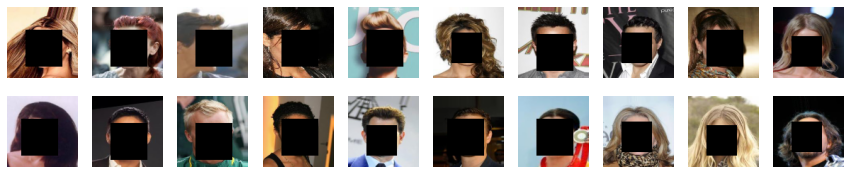

In [ ]:
# Hair

plt.figure(figsize=(15,3))
for k in range(20):
    im = res_hair[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im.astype('uint8'))
    #cv2_imshow(im)
    plt.axis("off")

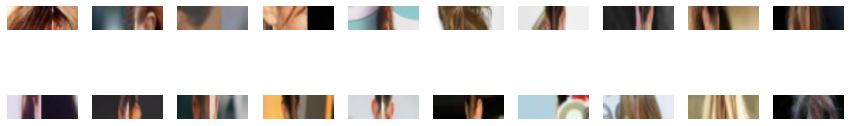

In [ ]:
# Ears

plt.figure(figsize=(15,3))
for k in range(20):
    im = res_ears[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im.astype('uint8'))
    #cv2_imshow(im)
    plt.axis("off")

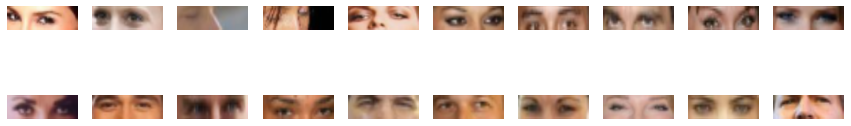

In [ ]:
# Eyes
plt.figure(figsize=(15,3))
for k in range(20):
    ec = ec_all[k]
    im = df[k]
    im = im[ec[0]:ec[1],ec[2]:ec[3]]
    im = resize(im, (30,90) )
    plt.subplot(2,10,k+1)
    plt.imshow(im.astype('uint8'))
    #cv2_imshow(im)
    plt.axis("off")

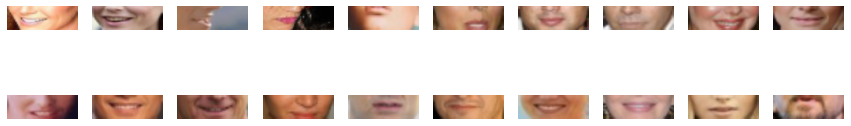

In [ ]:
# Mouth
plt.figure(figsize=(15,3))
for k in range(20):
    mc = mc_all[k]
    im = df[k]
    im = im[mc[0]:mc[1],mc[2]:mc[3]]
    im = resize(im, (30,90) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im.astype('uint8'))
    #cv2_imshow(im)
    plt.axis("off")

## 1.3 Training on Individual Isolated features 


In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def AUC(beta, X_test, y_test):
    prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
    pred_bool = prediction_batch(beta, X_test) > 0.5
    pred = 2*pred_bool - 1
    return(roc_auc_score(y_test, pred))

In [ ]:
# functions required
def prediction(beta, x):
    """
    desc:
    =====
    compute the probability that x is associated to a +1 label

    args:
    ====
     x: vector of dimension 784
     beta: vector of dimension 784 (logistic reg param)     
    """
    proba = 1. / (1. + np.exp(-np.dot(x,beta)))
    return proba

# let us now define a function tat can compute the error rate
@jax.jit
def compute_error_rate(beta, X, Y):
    # let us parallelize the function:
    prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
    
    # compute predictions
    pred_bool = prediction_batch(beta, X) > 0.5
    
    # convert to +1/-1 predictions
    pred = 2*pred_bool - 1
    
    # return the error rate
    return np.mean(Y == pred)

    
@jax.jit
def loss_single(beta, x, y):
    """
    desc:
    =====
    compute the loss for a single image

    args:
    ====
     beta: vector of dimension 784 (logistic reg param)
     x: vector of dimension 784
     y: {+1, -1} label
    """
    return np.log(1. + np.exp(-y * np.dot(x,beta)))

@jax.jit
def loss(beta, X, Y):
    """
    desc:
    ====
     logistic regression loss
    """
    # loss_single(beta, x, y)
    loss_all = jax.vmap(loss_single, in_axes=(None, 0, 0))
    
    # compute all the individual losses
    loss_individuals = loss_all(beta, X_train, y_train)
    
    # return the average loss
    return np.mean(loss_individuals)

# let us compute the gradient and compile
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))

In [ ]:
def SGD_momentum(X_train, X_test, y_train, y_test, beta_init):
    
    start_time = time.time()
    n_epoch = 10
    minibatch_size = 50 #size of the minibatchs
    N = len(X_train)
    img_indices = onp.arange(N)

    loss_history3 = []
    loss_history_end_epoch3 = []
    beta = onp.copy(beta_init)
    beta_previous = onp.copy(beta_init)
    learning_rate = 0.000001
    gamma = 0.9

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        onp.random.shuffle(img_indices) # need to keep the batches randomised

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = onp.arange(k*minibatch_size, (k+1)*minibatch_size) % N # to ensure that we stay in the range of N
            batch_indices = img_indices[batch_indices]
            X_minibatch = X_train[batch_indices]
            y_minibatch = y_train[batch_indices]

            # compute the stochastic gradient
            val, grad = loss_value_and_grad(beta, X_minibatch, y_minibatch)

            # do one step of SGD

            temp = beta
            beta = temp - learning_rate * grad + gamma * (temp - beta_previous)
            beta_previous = temp

            # book-keeping
            loss_history3.append(val)
            all_loss_within_epoch.append(val)
        loss_history_end_epoch3.append(onp.mean(all_loss_within_epoch))
        err_train = 100*compute_error_rate(beta, X_train, y_train)
        err_val= 100*compute_error_rate(beta, X_test, y_test)        
        print(f"iter:{epoch} \t Loss:{val:2.3f} \t error(train):{err_train:2.1f}% \t error(val):{err_val:2.1f}%")
    print("Took", time.time() - start_time, "s to run")
    return (loss_history3, loss_history_end_epoch3, beta)

In [ ]:
# training with eyes
X_train = onp.array(res_eyes[:15000]).reshape(15000, 30*90*3)
X_test = onp.array(res_eyes[15000:]).reshape(5000, 30*90*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(0)
beta_init_all = onp.random.normal(0,scale=1/np.sqrt(30*90*3),size=(30*90*3))
beta_init = beta_init_all.copy()

# fitting and testing model
eyes_SGD_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:2.334 	 error(train):69.0% 	 error(val):68.2%
iter:1 	 Loss:1.965 	 error(train):73.5% 	 error(val):73.8%
iter:2 	 Loss:1.983 	 error(train):73.5% 	 error(val):72.4%
iter:3 	 Loss:1.827 	 error(train):73.7% 	 error(val):74.1%
iter:4 	 Loss:1.928 	 error(train):73.7% 	 error(val):72.2%
iter:5 	 Loss:1.969 	 error(train):73.2% 	 error(val):73.6%
iter:6 	 Loss:1.895 	 error(train):75.1% 	 error(val):73.6%
iter:7 	 Loss:1.482 	 error(train):71.6% 	 error(val):69.6%
iter:8 	 Loss:8.522 	 error(train):58.4% 	 error(val):58.7%
iter:9 	 Loss:1.243 	 error(train):78.1% 	 error(val):76.9%
Took 329.5321207046509 s to run


Text(0.5, 1.0, 'Plot of SGD loss history for Eyes images')

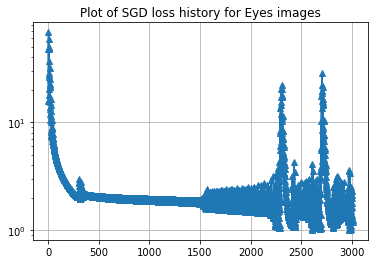

In [ ]:
plt.plot(eyes_SGD_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Plot of SGD loss history for Eyes images')

In [ ]:
AUC(eyes_SGD_loss_history[2], X_test, y_test)

0.7862858481058017

In [ ]:
# training with mouth
X_train = onp.array(res_mouth[:15000]).reshape(15000, 30*90*3)
X_test = onp.array(res_mouth[15000:]).reshape(5000, 30*90*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(0)
beta_init_all = onp.random.normal(0,scale=1/np.sqrt(30*90*3),size=(30*90*3))
beta_init = beta_init_all.copy()

# fitting and testing model
mouth_SGD_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:2.334 	 error(train):44.3% 	 error(val):44.1%
iter:1 	 Loss:1.965 	 error(train):51.3% 	 error(val):52.0%
iter:2 	 Loss:1.983 	 error(train):42.9% 	 error(val):42.8%
iter:3 	 Loss:1.827 	 error(train):51.1% 	 error(val):52.1%
iter:4 	 Loss:1.928 	 error(train):42.4% 	 error(val):42.2%
iter:5 	 Loss:1.969 	 error(train):51.2% 	 error(val):52.1%
iter:6 	 Loss:1.895 	 error(train):42.3% 	 error(val):42.3%
iter:7 	 Loss:1.482 	 error(train):41.5% 	 error(val):41.2%
iter:8 	 Loss:8.522 	 error(train):58.1% 	 error(val):58.2%
iter:9 	 Loss:1.243 	 error(train):42.1% 	 error(val):42.2%
Took 294.5355393886566 s to run


Text(0.5, 1.0, 'Plot of SGD loss history for Mouth images')

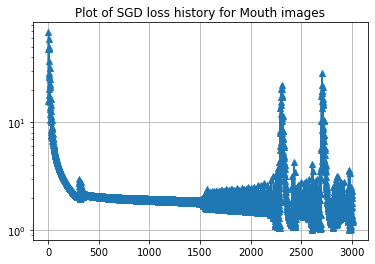

In [ ]:
plt.plot(mouth_SGD_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Plot of SGD loss history for Mouth images')

In [ ]:
AUC(mouth_SGD_loss_history[2], X_test, y_test)

0.4887095987501805

In [ ]:
# training with ears
X_train = onp.array(res_ears[:15000]).reshape(15000, 30*90*3)
X_test = onp.array(res_ears[15000:]).reshape(5000, 30*90*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(0)
beta_init_all = onp.random.normal(0,scale=1/np.sqrt(30*90*3),size=(30*90*3))
beta_init = beta_init_all.copy()

# fitting and testing model
ears_SGD_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:2.334 	 error(train):44.2% 	 error(val):43.5%
iter:1 	 Loss:1.965 	 error(train):46.7% 	 error(val):46.5%
iter:2 	 Loss:1.983 	 error(train):43.5% 	 error(val):43.2%
iter:3 	 Loss:1.827 	 error(train):46.7% 	 error(val):47.1%
iter:4 	 Loss:1.928 	 error(train):43.3% 	 error(val):43.5%
iter:5 	 Loss:1.969 	 error(train):47.2% 	 error(val):47.6%
iter:6 	 Loss:1.895 	 error(train):43.2% 	 error(val):43.5%
iter:7 	 Loss:1.482 	 error(train):43.5% 	 error(val):43.9%
iter:8 	 Loss:8.522 	 error(train):51.5% 	 error(val):51.5%
iter:9 	 Loss:1.243 	 error(train):43.5% 	 error(val):44.1%
Took 308.8947699069977 s to run


Text(0.5, 1.0, 'Plot of SGD loss history for Ears images')

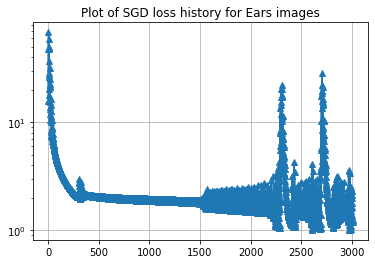

In [ ]:
plt.plot(ears_SGD_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Plot of SGD loss history for Ears images')

In [ ]:
AUC(ears_SGD_loss_history[2], X_test, y_test)

0.4899522088208975

In [ ]:
# training with hair
X_train = onp.array(res_hair[:15000]).reshape(15000, 100*100*3)
X_test = onp.array(res_hair[15000:]).reshape(5000, 100*100*3)
y_train = onp.array(attribute.loc[:14999, 'Male'])
y_test = onp.array(attribute.loc[15000:, 'Male'])

# parameter of the logistic regression, generate it at random
onp.random.seed(0)
beta_init_all = onp.random.normal(0,scale=1/np.sqrt(100*100*3),size=(100*100*3))
beta_init = beta_init_all.copy()


# fitting and testing model
hair_SGD_loss_history = SGD_momentum(X_train, X_test, y_train, y_test, beta_init)

iter:0 	 Loss:5.143 	 error(train):71.1% 	 error(val):71.3%
iter:1 	 Loss:5.802 	 error(train):70.1% 	 error(val):69.3%
iter:2 	 Loss:7.337 	 error(train):75.6% 	 error(val):73.8%
iter:3 	 Loss:7.208 	 error(train):72.4% 	 error(val):70.8%
iter:4 	 Loss:3.544 	 error(train):73.2% 	 error(val):70.1%
iter:5 	 Loss:2.172 	 error(train):80.4% 	 error(val):74.6%
iter:6 	 Loss:2.295 	 error(train):76.7% 	 error(val):72.9%
iter:7 	 Loss:2.991 	 error(train):78.4% 	 error(val):72.6%
iter:8 	 Loss:3.706 	 error(train):78.3% 	 error(val):75.3%
iter:9 	 Loss:2.729 	 error(train):73.0% 	 error(val):71.6%
Took 1140.1976218223572 s to run


Text(0.5, 1.0, 'Plot of SGD loss history for Hair images')

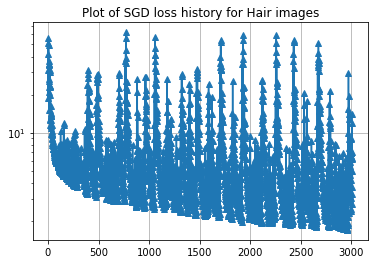

In [ ]:
plt.plot(hair_SGD_loss_history[0], "-^")
plt.yscale("log")
plt.grid(True)
plt.title('Plot of SGD loss history for Hair images')

In [ ]:
AUC(hair_SGD_loss_history[2], X_test, y_test)

0.6701071848694714

## 1.4 Ensemble of Models


In [ ]:
# get individual test data predicted probabilities for each model
prediction_batch = jax.vmap(prediction, in_axes=(None, 0))
X_test_hair = onp.array(res_hair[15000:]).reshape(5000, 100*100*3)
X_test_ears = onp.array(res_ears[15000:]).reshape(5000, 30*90*3)
X_test_eyes = onp.array(res_eyes[15000:]).reshape(5000, 30*90*3)
X_test_mouth = onp.array(res_mouth[15000:]).reshape(5000, 30*90*3)

eyes_SGD_testpred = prediction_batch(eyes_SGD_loss_history[2], X_test_eyes) > 0.5
mouth_SGD_testpred = prediction_batch(mouth_SGD_loss_history[2], X_test_mouth) > 0.5
ears_SGD_testpred = prediction_batch(ears_SGD_loss_history[2], X_test_ears) > 0.5
hair_SGD_testpred = prediction_batch(hair_SGD_loss_history[2], X_test_hair) > 0.5

In [ ]:
# get individual train data predicted probabilities for each model
X_train_hair = onp.array(res_hair[:15000]).reshape(15000, 100*100*3)
X_train_ears = onp.array(res_ears[:15000]).reshape(15000, 30*90*3)
X_train_eyes = onp.array(res_eyes[:15000]).reshape(15000, 30*90*3)
X_train_mouth = onp.array(res_mouth[:15000]).reshape(15000, 30*90*3)

eyes_SGD_trainpred = prediction_batch(eyes_SGD_loss_history[2], X_train_eyes) > 0.5
mouth_SGD_trainpred = prediction_batch(mouth_SGD_loss_history[2], X_train_mouth) > 0.5
ears_SGD_trainpred = prediction_batch(ears_SGD_loss_history[2], X_train_ears) > 0.5
hair_SGD_trainpred = prediction_batch(hair_SGD_loss_history[2], X_train_hair) > 0.5

In [ ]:
# converting boolean data to 1 and -1
def convert(arr):
    new = []
    for i in range(len(arr)):
        new.append(1 if arr[i] else -1)
    return np.array(new)

In [ ]:
eyes_test = convert(eyes_SGD_testpred)
mouth_test = convert(mouth_SGD_testpred)
ears_test = convert(ears_SGD_testpred)
hair_test = convert(hair_SGD_testpred)

eyes_train = convert(eyes_SGD_trainpred)
mouth_train = convert(mouth_SGD_trainpred)
ears_train = convert(ears_SGD_trainpred)
hair_train = convert(hair_SGD_trainpred)

In [ ]:
# eyes + mouth + hair
EyMH_proba_test = (mouth_test + eyes_test + hair_test)
EyMH_bool_test = EyMH_proba_test > 0
EyMH_predict_test = 2 * EyMH_bool_test - 1

EyMH_proba_train = (mouth_train + eyes_train + hair_train)
EyMH_bool_train = EyMH_proba_train > 0
EyMH_predict_train = 2 * EyMH_bool_train - 1

print('Train accuracy for eyes + mouth + hair is {}'.format(np.mean(y_train == EyMH_predict_train)))
print('Test accuracy for eyes + mouth + hair is {}'.format(np.mean(y_test == EyMH_predict_test)))
print('Test AUC for eyes + mouth + hair is {}'.format(roc_auc_score(y_test, EyMH_predict_test)))

Train accuracy for eyes + mouth + hair is 0.7786000000000001
Test accuracy for eyes + mouth + hair is 0.7622
Test AUC for eyes + mouth + hair is 0.777026584284731


In [ ]:
# eyes + hair + ears
EyEH_proba_test = (ears_test + eyes_test + hair_test)
EyEH_bool_test = EyEH_proba_test > 0
EyEH_predict_test = 2 * EyEH_bool_test - 1

EyEH_proba_train = (ears_train + eyes_train + hair_train)
EyEH_bool_train = EyEH_proba_train > 0
EyEH_predict_train = 2 * EyEH_bool_train - 1

print('Train accuracy for eyes + mouth + hair is {}'.format(np.mean(y_train == EyEH_predict_train)))
print('Test accuracy for eyes + hair + ears is {}'.format(np.mean(y_test == EyEH_predict_test)))
print('Test AUC for eyes + hair + ears is {}'.format(roc_auc_score(y_test, EyEH_predict_test)))

Train accuracy for eyes + mouth + hair is 0.7731333333333333
Test accuracy for eyes + hair + ears is 0.757
Test AUC for eyes + hair + ears is 0.7632599131675611


In [ ]:
# eyes + hair + ears + mouth
EyHEM_proba_test = (ears_test + eyes_test + hair_test + mouth_test)
EyHEM_bool_test = EyHEM_proba_test > 0
EyHEM_predict_test = 2 * EyHEM_bool_test - 1

EyHEM_proba_train = (ears_train + eyes_train + hair_train + mouth_train)
EyHEM_bool_train = EyHEM_proba_train > 0
EyHEM_predict_train = 2 * EyHEM_bool_train - 1

print('Train accuracy for eyes + hair + ears + mouth is {}'.format(np.mean(y_train == EyHEM_predict_train)))
print('Test accuracy for eyes + hair + ears + mouth is {}'.format(np.mean(y_test == EyHEM_predict_test)))
print('Test AUC for eyes + hair + ears + mouth is {}'.format(roc_auc_score(y_test, EyHEM_predict_test)))

Train accuracy for eyes + hair + ears + mouth is 0.7646000000000001
Test accuracy for eyes + hair + ears + mouth is 0.751
Test AUC for eyes + hair + ears + mouth is 0.7517672685684933
